In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Evaluate**

## Build function

In [2]:
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import json
from statistics import mean
import nltk.translate.bleu_score as bleu
import Levenshtein
import matplotlib.pyplot as plt

In [4]:
def find_indices(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

In [5]:
def add_multiple_target(input, target):
  targets = []
  for inp in input:
    targets_idx = find_indices(input, inp)
    targets.append(list(np.array(target)[targets_idx]))

  return targets

In [6]:
def calculate_f1(input, true, pred):
  correct_norm, total_norm, total_nsw = 0.0, 0.0, 0.0
  for i in range(len(input)):
    if input[i] != pred[i] and true[i] == pred[i]: # số token được chuẩn hóa đúng 3
      correct_norm += 1
    if input[i] != true[i]: # nsw trong câu 5
      total_nsw += 1
    if input[i] != pred[i]: # các token đc chuẩn hóa 3
      total_norm += 1

  p = r = f1 = 0.0
  if(total_norm!=0 and correct_norm!= 0): p = correct_norm / total_norm
  if(total_norm!=0 and total_nsw!= 0): r = correct_norm / total_nsw
  if p != 0 and r != 0: f1 =  (2 * p * r) / (p + r)

  return f1

In [7]:
def find_most_accurate_predictions(predictions, abbreviations, targets):
    '''Hàm liệt kê các từ viết tắt khác với từ đúng'''
    incorrect_predictions = {}

    for abbreviation_sentence, prediction_sentence, target_sentence in zip(abbreviations, predictions, targets):
        for abbreviation, prediction, target in zip(abbreviation_sentence, prediction_sentence, target_sentence):
            if abbreviation.lower() != target.lower():  # Kiểm tra từ viết tắt khác với từ đúng (không phân biệt hoa thường)
                if abbreviation in incorrect_predictions:
                    incorrect_predictions[abbreviation][0] += 1
                else:
                    incorrect_predictions[abbreviation] = [1, target]

    sorted_predictions = sorted(incorrect_predictions.items(), key=lambda x: x[1][0], reverse=True)
    return [(abbreviation, target, count) for abbreviation, (count, target) in sorted_predictions]

In [8]:
def line_chart(predictions, targets):
    num_sentences = len(predictions)
    x = range(num_sentences)

    fig, ax = plt.subplots(figsize=(20, 8))
    ax.plot(x, [len(pred) for pred in predictions], marker='o', linestyle='-', label='Predictions')
    ax.plot(x, [len(target) for target in targets], marker='o', linestyle='-', label='Targets')

    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Number of Words')
    ax.set_title('Comparison of Predictions and Targets')
    ax.legend()
    plt.xticks(x[::100])
    plt.show()

def scatter_plot(predictions, targets):
    num_sentences = len(predictions)
    x = range(num_sentences)

    fig, ax = plt.subplots(figsize=(20, 8))
    ax.scatter(x, [len(pred) for pred in predictions], color='blue', label='Predictions')
    ax.scatter(x, [len(target) for target in targets], color='red', label='Targets')

    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Number of Words')
    ax.set_title('Comparison of Predictions and Targets')
    ax.legend()
    plt.xticks(x[::100])
    plt.show()

In [9]:
def load(train_res, test_res):
  train_input = []
  train_target = []
  train_output = []
  train_score = []
  for sent in train_res:
    train_input.append(sent['input'])
    train_target.append(sent['target'])
    train_output.append(sent['output'])

  test_input = []
  test_target = []
  test_output = []
  test_score = []
  for sent in test_res:
    test_input.append(sent['input'])
    test_target.append(sent['target'])
    test_output.append(sent['output'])
  return train_input, train_target, train_output, test_input, test_target, test_output

In [10]:
def f1_bleu_score(train_input, train_output, train_targets, test_input, test_output, test_targets):
  f1_train = []
  for i in range(len(train_input)):
    scores = []
    input = train_input[i]
    targets = train_targets[i]
    output = train_output[i]
    true_token = []
    pred_token = []
    for target in targets:
      scores.append(calculate_f1(input, target, output))

    f1_train.append(max(scores))

  f1_test = []
  for i in range(len(test_input)):
    scores = []
    input = test_input[i]
    targets = test_targets[i]
    output = test_output[i]
    true_token = []
    pred_token = []
    for target in targets:
      scores.append(calculate_f1(input, target, output))

    f1_test.append(max(scores))

  bleu_train = []
  for i in range(len(train_input)):
    reference = train_targets[i]
    candidate = train_output[i]
    score = bleu.sentence_bleu(reference, candidate)
    bleu_train.append(score)

  bleu_test = []
  for i in range(len(test_input)):
    reference = test_targets[i]
    candidate = test_output[i]
    score = bleu.sentence_bleu(reference, candidate)
    bleu_test.append(score)

  print("Mean F1-score")
  print(mean(f1_train))
  print(mean(f1_test))
  print("===================")
  print("Mean BLEU-score")
  print(mean(bleu_train))
  print(mean(bleu_test))

  return f1_train, f1_test, bleu_train, bleu_test

In [11]:
def compare_predictions_targets(predictions, targets, inputs):
    '''Hàm So sánh đầu ra dự đoán với đầu ra mục tiêu'''
    for prediction, target, inputs in zip(predictions, targets, inputs):
        # Chuyển đổi chuỗi sang chữ thường (không phân biệt hoa thường) để so sánh
        prediction = [word.lower() for word in prediction]
        target = [word.lower() for word in target]

        # Kiểm tra độ dài của hai chuỗi
        if len(prediction) != len(target):
            print("Dự đoán sai: Độ dài không khớp")
            print("Đầu vào:", " ".join(inputs))
            print("Dự đoán:", " ".join(prediction))
            print("Mục tiêu:", " ".join(target))
            print()
            continue

        # So sánh từng từ trong chuỗi
        for pred_word, target_word in zip(prediction, target):
            if pred_word != target_word:
                print("Dự đoán sai:")
                print("Đầu vào:", " ".join(inputs))
                print("Dự đoán:", " ".join(prediction))
                print("Mục tiêu:", " ".join(target))
                print()
                break
        else:
            #print("Dự đoán chính xác:", " ".join(prediction))
            print("Dự đoán chính xác:")
            print("Đầu vào:", " ".join(inputs))
            print("Dự đoán:", " ".join(prediction))
            print("Mục tiêu:", " ".join(target))
            print()

In [12]:
def count_unnormalized_words(data):
    '''Số từ chưa chuẩn hóa trong tập dữ liệu (những từ chứa ít nhất một ký tự không phải là chữ cái)'''
    count = 0
    for sentence in data:
        for word in sentence:
            if not word.isalpha():
                count += 1
    return count

def count_words_to_normalize(data):
    '''Số từ cần chuẩn hóa trong tập dữ liệu (Tổng số từ trong dataset)'''
    count = 0
    for sentence in data:
        for word in sentence:
            count += 1
    return count

In [13]:
def calculate_error_percentage(target_sentence, output_sentence):
    total_words = len(target_sentence)
    error_count = 0

    for target_word, output_word in zip(target_sentence, output_sentence):
        if target_word != output_word:
            error_count += 1

    error_percentage = (error_count / total_words) * 100
    return error_percentage


def print_error_sentences(input_data, target_data, output_data):
    '''Các câu trong tập có tỷ lệ từ chưa được chuẩn hóa đúng'''
    for input_sentence, target_sentence, output_sentence in zip(input_data, target_data, output_data):
        error_percentage = calculate_error_percentage(target_sentence, output_sentence)
        if error_percentage > 0:
            print("Input: ", " ".join(input_sentence))
            print("Target: ", " ".join(target_sentence))
            print("Output: ", " ".join(output_sentence))
            print("Error percentage: {:.2f}%".format(error_percentage))
            print()

In [14]:
def calculate_normalization_percentage(target_data, output_data):
    '''Phần trăm từ đã được chuẩn hóa trong dữ liệu đầu ra so với dữ liệu mục tiêu'''
    total_words = 0
    normalized_words = 0

    for target_sentence, output_sentence in zip(target_data, output_data):
        for target_word, output_word in zip(target_sentence, output_sentence):
            total_words += 1
            if target_word == output_word:
                normalized_words += 1

    percentage = (normalized_words / total_words) * 100
    return percentage

def calculate_normalization_error_percentage(target_data, output_data):
    '''Tỷ lệ phần trăm lỗi từ đã được chuẩn hóa trong dữ liệu đầu ra so với dữ liệu mục tiêu'''
    total_words = 0
    normalized_words = 0

    for target_sentence, output_sentence in zip(target_data, output_data):
        for target_word, output_word in zip(target_sentence, output_sentence):
            total_words += 1
            if target_word == output_word:
                normalized_words += 1

    error_percentage = 100 - ((normalized_words / total_words) * 100)
    return error_percentage

In [15]:
def calculate_frequencies_probabilities(data):
    '''
    frequencies: tần số xuất hiện của các từ trong tập
    probabilities: xác suất xuất hiện của các từ trong tập
    '''
    frequencies = {}
    total_words = 0

    for sentence in data:
        for word in sentence:
            if word not in frequencies:
                frequencies[word] = 0
            frequencies[word] += 1
            total_words += 1

    probabilities = {word: count / total_words for word, count in frequencies.items()}

    return frequencies, probabilities

In [16]:
def calculate_accuracy(predictions, ground_truth):
    '''Tính accuracy của từng từ trong tập'''
    word_accuracy = {}

    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            word = predictions[i][j]
            if word not in word_accuracy:
                word_accuracy[word] = {'correct': 0, 'total': 0}
            word_accuracy[word]['total'] += 1
            if j < len(ground_truth[i]) and predictions[i][j] == ground_truth[i][j]:
                word_accuracy[word]['correct'] += 1

    for word in word_accuracy:
        accuracy = word_accuracy[word]['correct'] / word_accuracy[word]['total']
        word_accuracy[word] = accuracy
    return word_accuracy

def calculate_frequencies(data):
    '''Tính tần suất xuất hiện của từng từ trong tập'''
    frequencies = {}
    for i in range(len(data)):
        for word in data[i]:
            if word in frequencies:
                frequencies[word] += 1
            else:
                frequencies[word] = 1
    return frequencies

import numpy as np

def plot_relationship(train_frequencies, test_accuracy, title):
    '''Vẽ mối quan hệ giữa tần số xuất hiện của từ viết tắt trong tập train và khả năng dự đoán đúng của nó trong tập test'''
    words = []
    frequencies = []
    accuracies = []

    for word, frequency in train_frequencies.items():
        if word in test_accuracy:
            words.append(word)
            frequencies.append(frequency)
            accuracies.append(test_accuracy[word])

    plt.scatter(frequencies, accuracies)
    plt.xlabel('Frequencies in Training Set')
    plt.ylabel('Accuracy in Testing Set')
    plt.title(title)

    # Tính toán đường trendline
    z = np.polyfit(frequencies, accuracies, 1)
    p = np.poly1d(z)
    plt.plot(frequencies, p(frequencies), "r--")  # Vẽ đường trendline màu đỏ

    plt.show()

In [17]:
def analyze_error_by_sentence_length(target_sentences, output_sentences):
    '''Tác động của độ dài câu đến tỷ lệ lỗi'''
    sentence_lengths = [len(sentence) for sentence in target_sentences]
    error_percentages = [calculate_error_percentage(target_sentence, output_sentence) for target_sentence, output_sentence in zip(target_sentences, output_sentences)]

    # Tạo các nhóm câu theo độ dài câu
    grouped_data = {}
    for length, error_percentage in zip(sentence_lengths, error_percentages):
        if length not in grouped_data:
            grouped_data[length] = []
        grouped_data[length].append(error_percentage)

    # Tính toán tỷ lệ lỗi trung bình cho từng nhóm câu
    avg_error_percentages = {length: sum(errors) / len(errors) for length, errors in grouped_data.items()}

    # Trực quan hóa dữ liệu
    plt.bar(avg_error_percentages.keys(), avg_error_percentages.values())
    plt.xlabel('Sentence Length')
    plt.ylabel('Average Error Percentage')
    plt.title('Impact of Sentence Length on Error Rate')
    plt.show()

## Word Model

In [29]:
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2S/test.pred', 'r') as json_data:
    test_res = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2S/valid.pred', 'r') as json_data:
    train_res = json.load(json_data)

In [30]:
train_input, train_target, train_output, test_input, test_target, test_output = load(train_res, test_res)

In [31]:
train_targets = add_multiple_target(train_input, train_target)
test_targets = add_multiple_target(test_input, test_target)

print(len(train_targets))
print(len(test_targets))

219
219


<ipython-input-5-c592bf9ab45d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  targets.append(list(np.array(target)[targets_idx]))


In [32]:
f1_train, f1_test, bleu_train, bleu_test = f1_bleu_score(train_input, train_output, train_targets, test_input, test_output, test_targets)

Mean F1-score
0.542604058315152
0.561573363233388
Mean BLEU-score
0.6503697827023917
0.6870582884768347


In [33]:
print(find_indices(f1_train, 1.0))
print(find_indices(f1_test, 1.0))

[3, 9, 14, 17, 19, 25, 27, 29, 36, 39, 43, 44, 48, 49, 54, 57, 60, 62, 67, 69, 71, 74, 78, 83, 85, 86, 87, 90, 93, 94, 102, 107, 111, 113, 114, 119, 122, 123, 124, 128, 129, 135, 142, 144, 145, 151, 154, 156, 158, 163, 164, 165, 168, 172, 174, 178, 182, 185, 186, 188, 190, 199, 202, 206, 209, 210, 212, 213, 216, 218]
[9, 12, 13, 14, 15, 16, 27, 28, 41, 46, 47, 53, 54, 55, 59, 60, 62, 74, 77, 78, 79, 82, 85, 87, 88, 90, 93, 94, 100, 101, 108, 110, 114, 115, 120, 126, 127, 131, 132, 134, 143, 144, 145, 152, 154, 155, 165, 166, 174, 177, 180, 181, 183, 187, 189, 206, 208, 213, 214]


In [34]:
i = 7
print(train_res[i]['input'])
print(train_res[i]['target'])
print(train_res[i]['output'])

['kh', 'nghi', 'hau', 'qua', 've', 'sao', 'luon', 'ne', '..', 'chui', 'cho', 'suong', 'mieng', 'di', 'roi', 'hau', 'qua', 'se', 'ap', 'den', 'chi', 'ne', '..']
['không', 'nghĩ', 'hậu', 'quả', 'về', 'sau', 'luôn', 'nè', '..', 'chửi', 'cho', 'sướng', 'miệng', 'đi', 'rồi', 'hậu', 'quả', 'sẽ', 'ập', 'đến', 'chị', 'nè', '..']
['không', 'nghi', 'hậu', 'quá', 'về', 'sao', 'luôn', 'nè', '..', 'chửi', 'cho', 'suong', 'miệng', 'đi', 'rồi', 'hậu', 'qua', 'se', 'ap', 'đến', 'chị', 'nè', '..']


In [35]:
i = 7
print(test_res[i]['input'])
print(test_res[i]['target'])
print(test_res[i]['output'])

['trend', 'này', 'về', 'vn', 'ra', 'đường', 'dơ', 'lên', 'cái', 'lại', 'thâm', 'mắt', '🐒', 'các', 'idol', 'bậy', 'quá', '.']
['trend', 'này', 'về', 'việt nam', 'ra', 'đường', 'giơ', 'lên', 'cái', 'lại', 'thâm', 'mắt', '🐒', 'các', 'idol', 'bậy', 'quá', '.']
['trend', 'này', 'về', 'việt nam', 'ra', 'đường', 'dơ', 'lên', 'cái', 'lại', 'thâm', 'mắt', '🐒', 'các', 'idol', 'bậy', 'quá', '.']


In [36]:
train_normalization_percentage = calculate_normalization_percentage(train_target, train_output)
test_normalization_percentage = calculate_normalization_percentage(test_target, test_output)

print("Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập train: {:.2f}%".format(train_normalization_percentage))
print("Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập test: {:.2f}%".format(test_normalization_percentage))

Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập train: 89.83%
Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập test: 89.59%


In [37]:
train_incorrect_predictions = find_most_accurate_predictions(train_output, train_input, train_target)
print("Các từ viết tắt khác với từ đúng:")
for abbreviation, target, count in train_incorrect_predictions:
    print(f"Từ viết tắt: {abbreviation}, Từ đúng: {target}, Số lần dự đoán đúng: {count}")

Các từ viết tắt khác với từ đúng:
Từ viết tắt: t, Từ đúng: tớ, Số lần dự đoán đúng: 27
Từ viết tắt: k, Từ đúng: không, Số lần dự đoán đúng: 22
Từ viết tắt: dm, Từ đúng: địt mẹ, Số lần dự đoán đúng: 18
Từ viết tắt: m, Từ đúng: mày, Số lần dự đoán đúng: 18
Từ viết tắt: đc, Từ đúng: được, Số lần dự đoán đúng: 17
Từ viết tắt: ko, Từ đúng: không, Số lần dự đoán đúng: 16
Từ viết tắt: vl, Từ đúng: vãi lồn, Số lần dự đoán đúng: 10
Từ viết tắt: e, Từ đúng: em, Số lần dự đoán đúng: 10
Từ viết tắt: đm, Từ đúng: đụ má, Số lần dự đoán đúng: 10
Từ viết tắt: vn, Từ đúng: việt nam, Số lần dự đoán đúng: 8
Từ viết tắt: a, Từ đúng: , Số lần dự đoán đúng: 8
Từ viết tắt: r, Từ đúng: rồi, Số lần dự đoán đúng: 8
Từ viết tắt: j, Từ đúng: gì, Số lần dự đoán đúng: 7
Từ viết tắt: cc, Từ đúng: lí, Số lần dự đoán đúng: 6
Từ viết tắt: vcl, Từ đúng: vãi cả lồn, Số lần dự đoán đúng: 6
Từ viết tắt: c, Từ đúng: chị, Số lần dự đoán đúng: 6
Từ viết tắt: v, Từ đúng: vậy, Số lần dự đoán đúng: 5
Từ viết tắt: ma, Từ đúng: mà

In [38]:
test_incorrect_predictions = find_most_accurate_predictions(test_output, test_input, test_target)
print("Các từ viết tắt khác với từ đúng:")
for abbreviation, target, count in test_incorrect_predictions:
    print(f"Từ viết tắt: {abbreviation}, Từ đúng: {target}, Số lần dự đoán đúng: {count}")

Các từ viết tắt khác với từ đúng:
Từ viết tắt: t, Từ đúng: tôi, Số lần dự đoán đúng: 38
Từ viết tắt: ko, Từ đúng: không, Số lần dự đoán đúng: 31
Từ viết tắt: đc, Từ đúng: được, Số lần dự đoán đúng: 26
Từ viết tắt: m, Từ đúng: mày, Số lần dự đoán đúng: 25
Từ viết tắt: dm, Từ đúng: đụ má, Số lần dự đoán đúng: 19
Từ viết tắt: k, Từ đúng: không, Số lần dự đoán đúng: 18
Từ viết tắt: a, Từ đúng: anh, Số lần dự đoán đúng: 15
Từ viết tắt: vn, Từ đúng: việt nam, Số lần dự đoán đúng: 12
Từ viết tắt: e, Từ đúng: em, Số lần dự đoán đúng: 9
Từ viết tắt: vl, Từ đúng: vãi lồn, Số lần dự đoán đúng: 9
Từ viết tắt: đm, Từ đúng: đụ má, Số lần dự đoán đúng: 9
Từ viết tắt: j, Từ đúng: gì, Số lần dự đoán đúng: 9
Từ viết tắt: ng, Từ đúng: người, Số lần dự đoán đúng: 8
Từ viết tắt: r, Từ đúng: rồi, Số lần dự đoán đúng: 6
Từ viết tắt: tbt, Từ đúng: tổng bí thư, Số lần dự đoán đúng: 5
Từ viết tắt: ah, Từ đúng: à, Số lần dự đoán đúng: 5
Từ viết tắt: vs, Từ đúng: với, Số lần dự đoán đúng: 5
Từ viết tắt: v, Từ đún

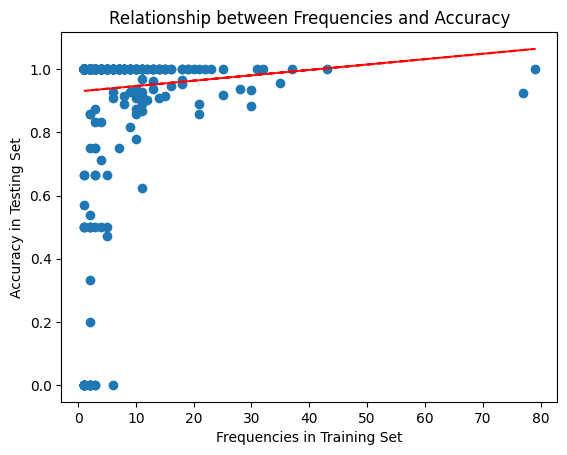

In [39]:
train_frequencies = calculate_frequencies(train_input)
test_accuracy = calculate_accuracy(test_output, test_target)
plot_relationship(train_frequencies, test_accuracy, "Relationship between Frequencies and Accuracy")

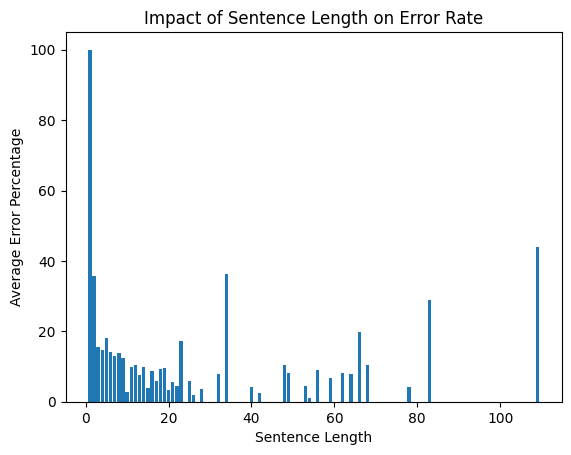

In [40]:
# Sử dụng hàm analyze_error_by_sentence_length
analyze_error_by_sentence_length(train_target, train_output)

In [41]:
max_distance = 0
max_distance_index = -1

for i, (output, target) in enumerate(zip(train_output, train_target)):
    distance = Levenshtein.distance(output, target)
    if distance > max_distance:
        max_distance = distance
        max_distance_index = i

if max_distance_index != -1:
    print(f"Maximum Levenshtein distance: {max_distance}")
    print("Input:", train_input[max_distance_index])
    print("Output:", train_output[max_distance_index])
    print("Target:", train_target[max_distance_index])
else:
    print("No maximum distance found.")

Maximum Levenshtein distance: 48
Input: ['tnao', 'thiếu', 'iot', 'thế', 'bạn', 'huy', 'minh', 'lương', '.', 'bạn', 'về', 'nhà', 'hỏi', 'lại', 'con', 'bà', 'già', 'nhà', 'bạn', 'ra', 'ngoài', 'chợ', 'nhặt', 'đc', 'tiền', 'về', 'có', 'khoe', 'loạn', 'nhà', 'hay', 'k', '.', 'hay', 'mang', 'tới', 'c', '.', 'a', 'tôi', 'nhặt', 'đc', '20k', '50k', 'k', 'biết', 'của', 'ai', 'tôi', 'mang', 'ra', 'trình', 'các', 'đồng', 'chí', '.', 'ai', 'cũng', 'có', 'lòng', 'tham', 'mà', 'những', 'ng', 'như', 'bạn', 'ăn', 'đủ', 'iot', 'lại', 'đéo', 'hiểu', 'cái', 'vđề', 'nó', 'nằm', 'ở', 'đâu', '.', 'ng', 'ta', 'mới', 'hỏi', 'là', 'có', 'nên', 'hốt', 'k', '.', 'chưa', 'ỉa', 'ra', 'mà', 'các', 'bạn', 'đã', 'chực', 'cắn', 'r', '.', 'lại', 'thêm', 'đc', '1', 'con', 'chó', 'to', 'nữa', ':))']
Output: ['thằng nào', 'thiếu', 'iot', 'thế', 'bạn', 'huy', 'minh', 'lương', '.', 'bạn', 'về', 'nhà', 'hỏi', 'lại', 'con', 'bà', 'già', 'nhà', 'bạn', 'ra', 'ngoài', 'chợ', 'nhặt', 'được', 'tiền', 'về', 'có', 'khoe', 'loạn', '

In [42]:
for output, target in zip(train_output, train_target):
    distance = Levenshtein.distance(output, target)
    print(f"Levenshtein distance between '{output}' and '{target}': {distance}")

Levenshtein distance between '['nhận', 'chữa', '✅', 'kinh', 'nguyệt', 'không', 'đều', '(', 'kinh', 'vón', 'cục', ',', 'thâm', ')', '✅', 'lạc', 'nội', 'mạc', 'tử', 'cũng', '✅', 'đau', 'bụng', 'kinh', '✅', 'tinh', 'trùng', 'yếu', ',', 'loãng', 'tin', '97', '✅', 'đa', 'nang', 'buồng', 'trứng', '✅', 'trứng', 'lép', ',', 'ta', 'chậm', 'phát', 'triển', 'cách', 'giới', '✅', 'tinh', 'trùng', 'yếu', '✅', 'tinh', 'trùng', 'vậy', 'dạng', '✅', 'sinh', 'lý', 'ruộng', 'tin', 'trùng', 'chuyên', '984888', 'theo', '291']' and '['nhận', 'chữa', '✅', 'kinh', 'nguyệt', 'không', 'đều', '(', 'kinh', 'vón', 'cục', ',', 'thâm', ')', '✅', 'lạc', 'nội', 'mạc', 'tử', 'cung', '✅', 'đau', 'bụng', 'kinh', '✅', 'tinh', 'trùng', 'yếu', ',', 'loãng', 'tinh', 'trùng', '✅', 'đa', 'nang', 'buồng', 'trứng', '✅', 'trứng', 'lép', ',', 'trứng', 'chậm', 'phát', 'triển', 'nam', 'giới', '✅', 'tinh', 'trùng', 'yếu', '✅', 'tinh', 'trùng', 'dị', 'dạng', '✅', 'sinh', 'lý', 'yếu', 'call', 'inbox', ':', '984888291', '', '']': 13
Leve

In [43]:
# So sánh đầu ra dự đoán với đầu ra mục tiêu trên tập test
compare_predictions_targets(test_output, test_target, test_input)

Dự đoán sai:
Đầu vào: dm ... thằng assmin này phản lại cái động ... bố nó thông minh , tài giỏi mới làm lãnh đạo ... nó có gen di truyền thông minh , tài giỏi đó mới làm lãnh đạo như bố nó ... không lẽ mày muốn thằng phụ bếp làm " tủ lạnh " , thằng thiến heo làm tbt ... v .. v .. dm có mà xuống hố cả nút đất nước này ah ... dm ...
Dự đoán: đụ mẹ ... thằng assmin này phản lại cái động ... bố nó thông minh , tài giỏi mới làm lãnh đạo ... nó có gen di truyền thông minh , tài giỏi đó mới làm lãnh đạo như bố nó ... không lẽ mày muốn thằng phụ bếp làm " tủ lạnh " , thằng thiến heo làm tổng bí thư ... v .. v .. đụ mẹ có mà xuống hố cả nút đất nước này á ... hố ...
Mục tiêu: đụ má ... thằng assmin này phản lại cái động ... bố nó thông minh , tài giỏi mới làm lãnh đạo ... nó có gen di truyền thông minh , tài giỏi đó mới làm lãnh đạo như bố nó ... không lẽ mày muốn thằng phụ bếp làm " tủ lạnh " , thằng thiến heo làm tổng bí thư ... v .. v .. đụ má có mà xuống hố cả nút đất nước này à ... địt mẹ 

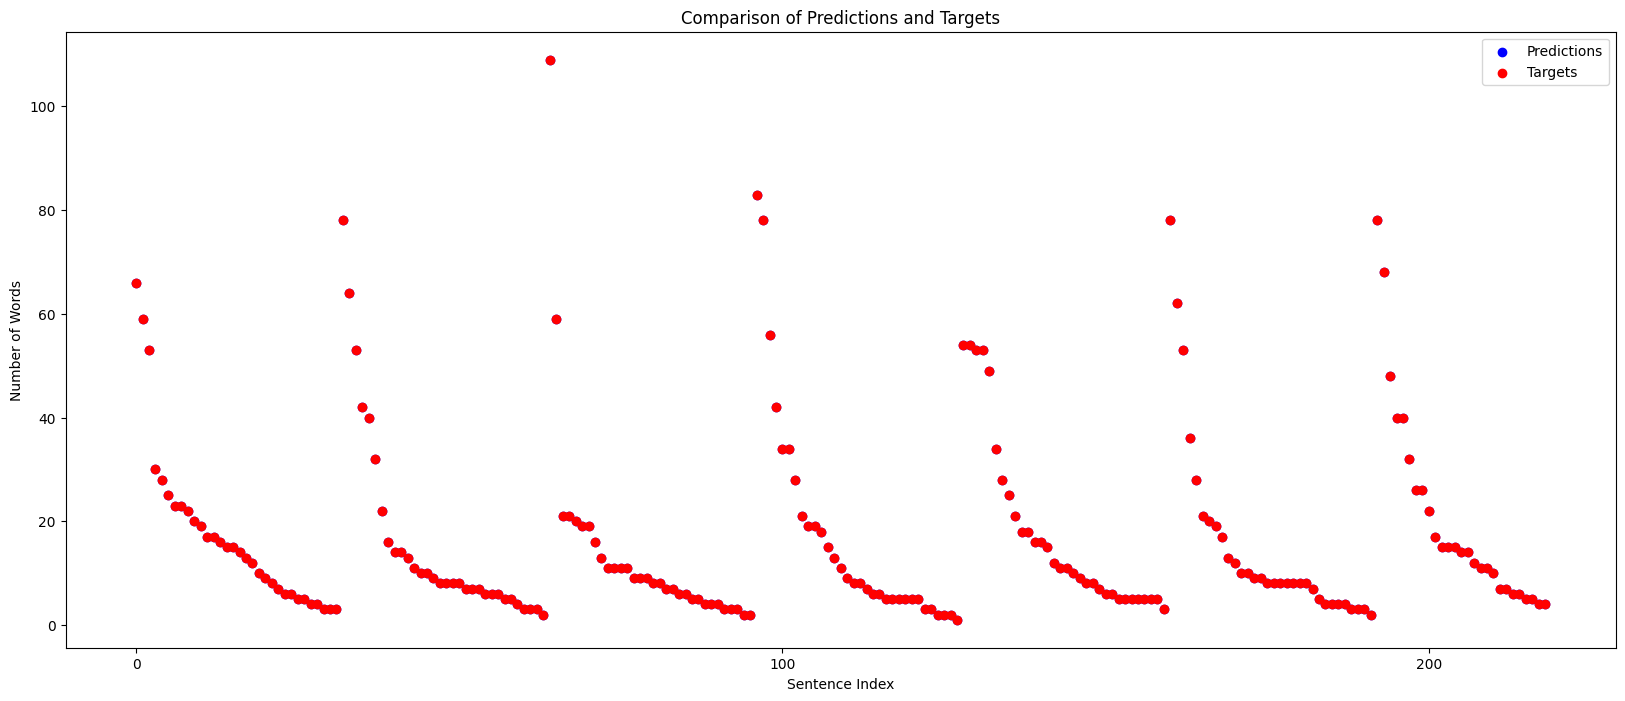

In [44]:
scatter_plot(train_output, train_target)

In [45]:
# Dữ liệu tần suất và xác suất từ tập huấn luyện và tập kiểm thử
train_frequencies, train_probabilities = calculate_frequencies_probabilities(train_input)
test_frequencies, test_probabilities = calculate_frequencies_probabilities(test_input)

print("Train Frequencies:", train_frequencies)
print("Train Probabilities:", train_probabilities)
print("Test Frequencies:", test_frequencies)
print("Test Probabilities:", test_probabilities)

Train Frequencies: {'nhận': 2, 'chữa': 3, '✅': 9, 'kinh': 6, 'nguyệt': 1, 'không': 11, 'đều': 2, '(': 2, 'vón': 1, 'cục': 1, ',': 79, 'thâm': 1, ')': 2, 'lạc': 1, 'nội': 2, 'mạc': 1, 'tử': 2, 'cung': 3, 'đau': 1, 'bụng': 1, 'tinh': 4, 'trùng': 4, 'yếu': 3, 'loãng': 1, 'đa': 1, 'nang': 1, 'buồng': 1, 'trứng': 3, 'lép': 1, 'chậm': 3, 'phát': 5, 'triển': 1, 'nam': 3, 'giới': 2, 'dị': 6, 'dạng': 1, 'sinh': 11, 'lý': 3, 'call': 1, 'inbox': 1, ':': 4, '984888': 1, '.': 77, '291': 1, 'coi': 4, 'cái': 32, 'này': 30, 'nè': 4, 'thành': 5, 'viên': 6, 'facebook': 4, 'thân': 1, 'mến': 1, 'là': 37, 'giả': 3, 'sử': 1, 'để': 14, 'được': 11, 'đóng': 1, 'cửa': 1, 'gần': 2, 'đây': 8, 'nó': 28, 'đang': 7, 'trở': 3, 'nên': 11, 'quá': 11, 'đông': 1, 'đã': 5, 'có': 35, 'nhiều': 2, 'phàn': 1, 'nàn': 1, 'rằng': 3, 'rất': 2, 'hồ': 4, 'sơ': 1, 'cho': 22, 'thấy': 16, 'hoạt': 1, 'động': 9, 'v': 13, 'trương': 5, 'hải': 6, 'yến': 6, 'ờ': 5, 'đúng': 10, 't': 27, 'ứng': 5, 'lắm': 19, 'luôn': 11, 'ở': 15, 'nhà': 14, 'c

In [46]:
from collections import defaultdict
from operator import itemgetter

def get_word_frequency(data):
    word_frequency = defaultdict(int)
    for sentence in data:
        for word in sentence:
            word_frequency[word] += 1

    return word_frequency

def get_top_words(word_frequency, n):
    sorted_words = sorted(word_frequency.items(), key=itemgetter(1), reverse=True)
    top_words = sorted_words[:n]
    return top_words

def calculate_word_frequency(train_input, train_target):
    word_frequency = defaultdict(int)
    for i in range(len(train_input)):
        sentence = train_input[i]
        target_sentence = train_target[i]
        for j in range(len(sentence)):
            word = sentence[j]
            target_word = target_sentence[j]
            # Kiểm tra nếu từ đó là từ viết tắt và mô hình đã dự đoán đúng
            if word == target_word:
                word_frequency[word] += 1
    return word_frequency

train_word_frequency = calculate_word_frequency(train_input, train_target)

#print("Tần suất xuất hiện của từ viết tắt trong tập train input:")
#for word, frequency in train_word_frequency.items():
#    print(f"Từ viết tắt: {word}, Tần suất xuất hiện: {frequency}")

top_words_train = get_top_words(train_word_frequency, 10)

print("\nTop 10 từ viết tắt trong tập train input:")
for word, frequency in top_words_train:
    print(f"Từ viết tắt: {word}, Tần suất xuất hiện: {frequency}")


Top 10 từ viết tắt trong tập train input:
Từ viết tắt: ,, Tần suất xuất hiện: 79
Từ viết tắt: ., Tần suất xuất hiện: 75
Từ viết tắt: ..., Tần suất xuất hiện: 43
Từ viết tắt: là, Tần suất xuất hiện: 37
Từ viết tắt: có, Tần suất xuất hiện: 35
Từ viết tắt: cái, Tần suất xuất hiện: 32
Từ viết tắt: làm, Tần suất xuất hiện: 31
Từ viết tắt: này, Tần suất xuất hiện: 30
Từ viết tắt: mà, Tần suất xuất hiện: 30
Từ viết tắt: nó, Tần suất xuất hiện: 28


In [47]:
def calculate_word_accuracy(train_input, train_target, train_output):
    word_accuracy = defaultdict(lambda: [0, 0])  # [số lần dự đoán đúng, tổng số lần xuất hiện]
    for i in range(len(train_input)):
        sentence = train_input[i]
        target_sentence = train_target[i]
        output_sentence = train_output[i]
        for j in range(len(sentence)):
            word = sentence[j]
            target_word = target_sentence[j]
            output_word = output_sentence[j]
            word_accuracy[word][1] += 1
            if output_word == target_word:
                word_accuracy[word][0] += 1
                word_accuracy[word].append(target_word)  # Gán từ đúng vào biến chung

    return word_accuracy



def print_word_ranking(word_accuracy):
    sorted_accuracy = sorted(word_accuracy.items(), key=lambda x: x[1][0], reverse=True)
    for word, accuracy in sorted_accuracy:
        correct = accuracy[0]
        total = accuracy[1]
        accuracy_percentage = (correct / total) * 100 if total > 0 else 0
        target_word = accuracy[2] if len(accuracy) > 2 else "Không có từ dự đoán"
        print(f"Từ viết tắt: {word}, Từ đúng: {target_word}, Xếp hạng: {correct}/{total}, Xác suất dự đoán đúng: {accuracy_percentage:.2f}%")


#train_word_accuracy = calculate_word_accuracy(train_input, train_target, train_output)

#print("Xếp hạng các từ viết tắt trong tập train input:")
#print_word_ranking(train_word_accuracy)

def print_incorrect_predictions(word_accuracy):
    for word, accuracy in word_accuracy.items():
        correct = accuracy[0]
        total = accuracy[1]
        target_word = accuracy[2] if len(accuracy) > 2 else None
        if target_word and word != target_word:
            accuracy_percentage = (correct / total) * 100 if total > 0 else 0
            print(f"Từ viết tắt: {word}, Từ đúng: {target_word}, Xếp hạng: {correct}/{total}, Xác suất dự đoán đúng: {accuracy_percentage:.2f}%")

train_word_accuracy = calculate_word_accuracy(train_input, train_target, train_output)

print("Các từ viết tắt không khớp với từ đúng ban đầu:")
print_incorrect_predictions(train_word_accuracy)

Các từ viết tắt không khớp với từ đúng ban đầu:
Từ viết tắt: cung, Từ đúng: cũng, Xếp hạng: 2/3, Xác suất dự đoán đúng: 66.67%
Từ viết tắt: t, Từ đúng: tao, Xếp hạng: 9/27, Xác suất dự đoán đúng: 33.33%
Từ viết tắt: đc, Từ đúng: được, Xếp hạng: 16/17, Xác suất dự đoán đúng: 94.12%
Từ viết tắt: vn, Từ đúng: việt nam, Xếp hạng: 8/8, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: bon, Từ đúng: bọn, Xếp hạng: 1/2, Xác suất dự đoán đúng: 50.00%
Từ viết tắt: vs, Từ đúng: với, Xếp hạng: 2/2, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: dm, Từ đúng: đụ mẹ, Xếp hạng: 1/18, Xác suất dự đoán đúng: 5.56%
Từ viết tắt: ko, Từ đúng: không, Xếp hạng: 16/16, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: kh, Từ đúng: không, Xếp hạng: 1/1, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: hau, Từ đúng: hậu, Xếp hạng: 2/2, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: qua, Từ đúng: quá, Xếp hạng: 1/4, Xác suất dự đoán đúng: 25.00%
Từ viết tắt: ve, Từ đúng: về, Xếp hạng: 1/1, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: 

In [48]:
def print_incorrect_predictions(word_accuracy):
    incorrect_predictions = [(word, accuracy) for word, accuracy in word_accuracy.items() if len(accuracy) > 2 and accuracy[2] != word]
    sorted_predictions = sorted(incorrect_predictions, key=lambda x: x[1][0] / x[1][1], reverse=True)
    for word, accuracy in sorted_predictions:
        correct = accuracy[0]
        total = accuracy[1]
        accuracy_percentage = (correct / total) * 100 if total > 0 else 0
        target_word = accuracy[2]
        if accuracy_percentage < 100:
            print(f"Từ viết tắt: {word}, Từ đúng: {target_word}, Xếp hạng: {correct}/{total}, Xác suất dự đoán đúng: {accuracy_percentage:.2f}%")
        else:
            print(f"Từ viết tắt: {word}, Từ đúng: {target_word}, Xếp hạng: {correct}/{total}, Xác suất dự đoán đúng: {accuracy_percentage:.2f}%")

train_word_accuracy = calculate_word_accuracy(train_input, train_target, train_output)

print("Các từ viết tắt không khớp với từ đúng ban đầu và được sắp xếp theo xác suất dự đoán đúng:")
print_incorrect_predictions(train_word_accuracy)

Các từ viết tắt không khớp với từ đúng ban đầu và được sắp xếp theo xác suất dự đoán đúng:
Từ viết tắt: vn, Từ đúng: việt nam, Xếp hạng: 8/8, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: vs, Từ đúng: với, Xếp hạng: 2/2, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: ko, Từ đúng: không, Xếp hạng: 16/16, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: kh, Từ đúng: không, Xếp hạng: 1/1, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: hau, Từ đúng: hậu, Xếp hạng: 2/2, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: ve, Từ đúng: về, Xếp hạng: 1/1, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: luon, Từ đúng: luôn, Xếp hạng: 1/1, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: ne, Từ đúng: nè, Xếp hạng: 2/2, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: chui, Từ đúng: chửi, Xếp hạng: 2/2, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: mieng, Từ đúng: miệng, Xếp hạng: 1/1, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: di, Từ đúng: đi, Xếp hạng: 5/5, Xác suất dự đoán đúng: 100.00%
Từ viết tắt: roi, Từ đúng: rồi, Xếp hạng: 

## S2SSelf

In [49]:
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2SSelf/test.pred', 'r') as json_data:
    test_res_S2SSelf = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2SSelf/valid.pred', 'r') as json_data:
    train_res_S2SSelf = json.load(json_data)

In [50]:
train_input_S2SSelf, train_target_S2SSelf, train_output_S2SSelf, test_input_S2SSelf, test_target_S2SSelf, test_output_S2SSelf = load(train_res_S2SSelf, test_res_S2SSelf)

In [51]:
train_targets_S2SSelf = add_multiple_target(train_input_S2SSelf, train_target_S2SSelf)
test_targets_S2SSelf = add_multiple_target(test_input_S2SSelf, test_target_S2SSelf)

print(len(train_targets_S2SSelf))
print(len(test_targets_S2SSelf))

219
219


<ipython-input-5-c592bf9ab45d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  targets.append(list(np.array(target)[targets_idx]))


In [52]:
f1_train_S2SSelf, f1_test_S2SSelf, bleu_train_S2SSelf, bleu_test_S2SSelf = f1_bleu_score(train_input_S2SSelf, train_output_S2SSelf, train_targets_S2SSelf, test_input_S2SSelf, test_output_S2SSelf, test_targets_S2SSelf)

Mean F1-score
0.40878356877551075
0.37647776886930373
Mean BLEU-score
0.5755608227946879
0.5840170150784709


In [53]:
train_S2SSelf_normalization_percentage = calculate_normalization_percentage(train_target_S2SSelf, train_output_S2SSelf)
test_S2SSelf_normalization_percentage = calculate_normalization_percentage(test_target_S2SSelf, test_output_S2SSelf)

print("Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập train: {:.2f}%".format(train_S2SSelf_normalization_percentage))
print("Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập test: {:.2f}%".format(test_S2SSelf_normalization_percentage))

Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập train: 87.87%
Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập test: 86.37%


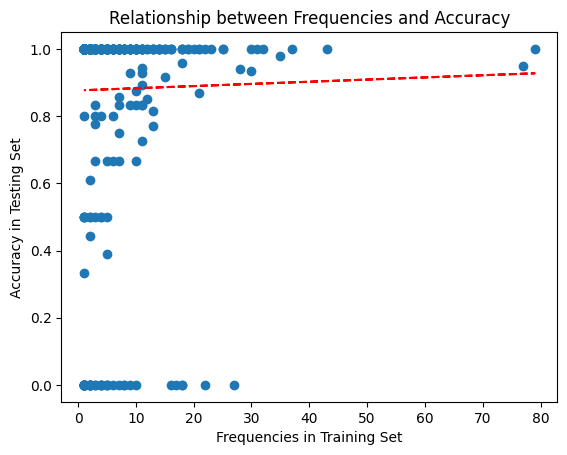

In [54]:
train_frequencies_S2SSelf = calculate_frequencies(train_input_S2SSelf)
test_accuracy_S2SSelf = calculate_accuracy(test_output_S2SSelf, test_target_S2SSelf)
plot_relationship(train_frequencies_S2SSelf, test_accuracy_S2SSelf, "Relationship between Frequencies and Accuracy")

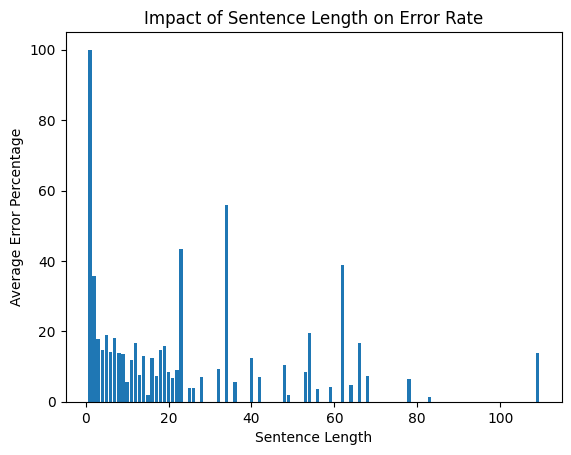

In [55]:
# Sử dụng hàm analyze_error_by_sentence_length
analyze_error_by_sentence_length(train_target_S2SSelf, train_output_S2SSelf)

In [56]:
train_S2SSelf_incorrect_predictions = find_most_accurate_predictions(train_output_S2SSelf, train_input_S2SSelf, train_target_S2SSelf)
print("Các từ viết tắt khác với từ đúng:")
for abbreviation, target, count in train_S2SSelf_incorrect_predictions:
    print(f"Từ viết tắt: {abbreviation}, Từ đúng: {target}, Số lần dự đoán đúng: {count}")

Các từ viết tắt khác với từ đúng:
Từ viết tắt: t, Từ đúng: tớ, Số lần dự đoán đúng: 27
Từ viết tắt: k, Từ đúng: không, Số lần dự đoán đúng: 22
Từ viết tắt: dm, Từ đúng: địt mẹ, Số lần dự đoán đúng: 18
Từ viết tắt: m, Từ đúng: mày, Số lần dự đoán đúng: 18
Từ viết tắt: đc, Từ đúng: được, Số lần dự đoán đúng: 17
Từ viết tắt: ko, Từ đúng: không, Số lần dự đoán đúng: 16
Từ viết tắt: vl, Từ đúng: vãi lồn, Số lần dự đoán đúng: 10
Từ viết tắt: e, Từ đúng: em, Số lần dự đoán đúng: 10
Từ viết tắt: đm, Từ đúng: đụ má, Số lần dự đoán đúng: 10
Từ viết tắt: vn, Từ đúng: việt nam, Số lần dự đoán đúng: 8
Từ viết tắt: a, Từ đúng: , Số lần dự đoán đúng: 8
Từ viết tắt: r, Từ đúng: rồi, Số lần dự đoán đúng: 8
Từ viết tắt: j, Từ đúng: gì, Số lần dự đoán đúng: 7
Từ viết tắt: cc, Từ đúng: lí, Số lần dự đoán đúng: 6
Từ viết tắt: vcl, Từ đúng: vãi cả lồn, Số lần dự đoán đúng: 6
Từ viết tắt: c, Từ đúng: chị, Số lần dự đoán đúng: 6
Từ viết tắt: v, Từ đúng: vậy, Số lần dự đoán đúng: 5
Từ viết tắt: ma, Từ đúng: mà

In [57]:
test_S2SSelf_incorrect_predictions = find_most_accurate_predictions(test_output_S2SSelf, test_input_S2SSelf, test_target_S2SSelf)
print("Các từ viết tắt khác với từ đúng:")
for abbreviation, target, count in test_S2SSelf_incorrect_predictions:
    print(f"Từ viết tắt: {abbreviation}, Từ đúng: {target}, Số lần dự đoán đúng: {count}")

Các từ viết tắt khác với từ đúng:
Từ viết tắt: t, Từ đúng: tôi, Số lần dự đoán đúng: 38
Từ viết tắt: ko, Từ đúng: không, Số lần dự đoán đúng: 31
Từ viết tắt: đc, Từ đúng: được, Số lần dự đoán đúng: 26
Từ viết tắt: m, Từ đúng: mày, Số lần dự đoán đúng: 25
Từ viết tắt: dm, Từ đúng: đụ má, Số lần dự đoán đúng: 19
Từ viết tắt: k, Từ đúng: không, Số lần dự đoán đúng: 18
Từ viết tắt: a, Từ đúng: anh, Số lần dự đoán đúng: 15
Từ viết tắt: vn, Từ đúng: việt nam, Số lần dự đoán đúng: 12
Từ viết tắt: e, Từ đúng: em, Số lần dự đoán đúng: 9
Từ viết tắt: vl, Từ đúng: vãi lồn, Số lần dự đoán đúng: 9
Từ viết tắt: đm, Từ đúng: đụ má, Số lần dự đoán đúng: 9
Từ viết tắt: j, Từ đúng: gì, Số lần dự đoán đúng: 9
Từ viết tắt: ng, Từ đúng: người, Số lần dự đoán đúng: 8
Từ viết tắt: r, Từ đúng: rồi, Số lần dự đoán đúng: 6
Từ viết tắt: tbt, Từ đúng: tổng bí thư, Số lần dự đoán đúng: 5
Từ viết tắt: ah, Từ đúng: à, Số lần dự đoán đúng: 5
Từ viết tắt: vs, Từ đúng: với, Số lần dự đoán đúng: 5
Từ viết tắt: v, Từ đún

## S2SMulti

In [58]:
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2SMulti/test.pred', 'r') as json_data:
    test_res_S2SMulti = json.load(json_data)
with open('/content/drive/MyDrive/Khai thác dữ liệu truyền thông xã hội - IE403.N22/Đồ án/Code/TextNormSeq2Seq/S2SMulti/valid.pred', 'r') as json_data:
    train_res_S2SMulti = json.load(json_data)

In [59]:
train_input_S2SMulti, train_target_S2SMulti, train_output_S2SMulti, test_input_S2SMulti, test_target_S2SMulti, test_output_S2SMulti = load(train_res_S2SMulti, test_res_S2SMulti)

In [60]:
train_targets_S2SMulti = add_multiple_target(train_input_S2SMulti, train_target_S2SMulti)
test_targets_S2SMulti = add_multiple_target(test_input_S2SMulti, test_target_S2SMulti)

print(len(train_targets_S2SMulti))
print(len(test_targets_S2SMulti))

219
219


<ipython-input-5-c592bf9ab45d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  targets.append(list(np.array(target)[targets_idx]))


In [61]:
f1_train_S2SMulti, f1_test_S2SMulti, bleu_train_S2SMulti, bleu_test_S2SMulti = f1_bleu_score(train_input_S2SMulti, train_output_S2SMulti, train_targets_S2SMulti,
                                                                                             test_input_S2SMulti, test_output_S2SMulti, test_targets_S2SMulti)

Mean F1-score
0.55625535021113
0.5830218057597293
Mean BLEU-score
0.6526358149375606
0.6971257812210854


In [62]:
train_S2SMulti_normalization_percentage = calculate_normalization_percentage(train_target_S2SMulti, train_output_S2SMulti)
test_S2SMulti_normalization_percentage = calculate_normalization_percentage(test_target_S2SMulti, test_output_S2SMulti)

print("Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập train: {:.2f}%".format(train_S2SMulti_normalization_percentage))
print("Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập test: {:.2f}%".format(test_S2SMulti_normalization_percentage))

Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập train: 89.99%
Tỷ lệ tương đồng giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu trên tập test: 90.67%


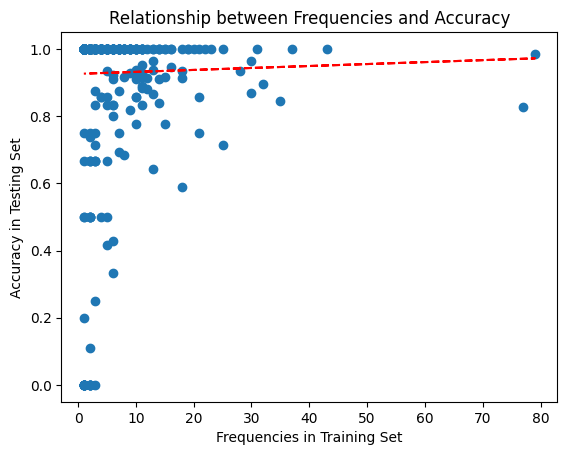

In [63]:
train_frequencies_S2SMulti = calculate_frequencies(train_input_S2SMulti)
test_accuracy_S2SMulti = calculate_accuracy(test_output_S2SMulti, test_target_S2SMulti)
plot_relationship(train_frequencies_S2SMulti, test_accuracy_S2SMulti, "Relationship between Frequencies and Accuracy")

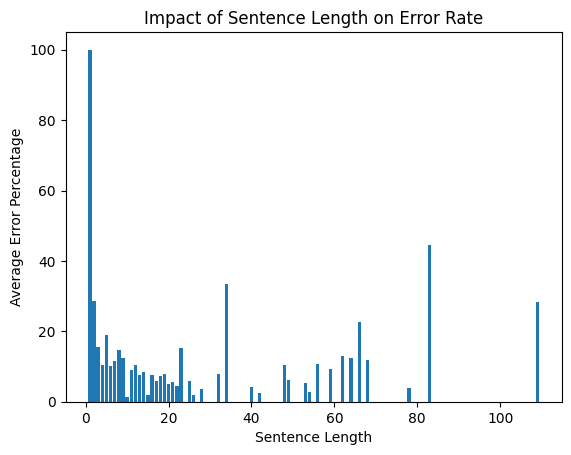

In [64]:
# Sử dụng hàm analyze_error_by_sentence_length
analyze_error_by_sentence_length(train_target_S2SMulti, train_output_S2SMulti)

In [65]:
test_incorrect_predictions = find_most_accurate_predictions(test_output, test_input, test_target)
print("Các từ viết tắt khác với từ đúng:")
for abbreviation, target, count in test_incorrect_predictions:
    print(f"Từ viết tắt: {abbreviation}, Từ đúng: {target}, Số lần dự đoán đúng: {count}")

Các từ viết tắt khác với từ đúng:
Từ viết tắt: t, Từ đúng: tôi, Số lần dự đoán đúng: 38
Từ viết tắt: ko, Từ đúng: không, Số lần dự đoán đúng: 31
Từ viết tắt: đc, Từ đúng: được, Số lần dự đoán đúng: 26
Từ viết tắt: m, Từ đúng: mày, Số lần dự đoán đúng: 25
Từ viết tắt: dm, Từ đúng: đụ má, Số lần dự đoán đúng: 19
Từ viết tắt: k, Từ đúng: không, Số lần dự đoán đúng: 18
Từ viết tắt: a, Từ đúng: anh, Số lần dự đoán đúng: 15
Từ viết tắt: vn, Từ đúng: việt nam, Số lần dự đoán đúng: 12
Từ viết tắt: e, Từ đúng: em, Số lần dự đoán đúng: 9
Từ viết tắt: vl, Từ đúng: vãi lồn, Số lần dự đoán đúng: 9
Từ viết tắt: đm, Từ đúng: đụ má, Số lần dự đoán đúng: 9
Từ viết tắt: j, Từ đúng: gì, Số lần dự đoán đúng: 9
Từ viết tắt: ng, Từ đúng: người, Số lần dự đoán đúng: 8
Từ viết tắt: r, Từ đúng: rồi, Số lần dự đoán đúng: 6
Từ viết tắt: tbt, Từ đúng: tổng bí thư, Số lần dự đoán đúng: 5
Từ viết tắt: ah, Từ đúng: à, Số lần dự đoán đúng: 5
Từ viết tắt: vs, Từ đúng: với, Số lần dự đoán đúng: 5
Từ viết tắt: v, Từ đún

In [66]:
train_incorrect_predictions = find_most_accurate_predictions(train_output, train_input, train_target)
print("Các từ viết tắt khác với từ đúng:")
for abbreviation, target, count in train_incorrect_predictions:
    print(f"Từ viết tắt: {abbreviation}, Từ đúng: {target}, Số lần dự đoán đúng: {count}")

Các từ viết tắt khác với từ đúng:
Từ viết tắt: t, Từ đúng: tớ, Số lần dự đoán đúng: 27
Từ viết tắt: k, Từ đúng: không, Số lần dự đoán đúng: 22
Từ viết tắt: dm, Từ đúng: địt mẹ, Số lần dự đoán đúng: 18
Từ viết tắt: m, Từ đúng: mày, Số lần dự đoán đúng: 18
Từ viết tắt: đc, Từ đúng: được, Số lần dự đoán đúng: 17
Từ viết tắt: ko, Từ đúng: không, Số lần dự đoán đúng: 16
Từ viết tắt: vl, Từ đúng: vãi lồn, Số lần dự đoán đúng: 10
Từ viết tắt: e, Từ đúng: em, Số lần dự đoán đúng: 10
Từ viết tắt: đm, Từ đúng: đụ má, Số lần dự đoán đúng: 10
Từ viết tắt: vn, Từ đúng: việt nam, Số lần dự đoán đúng: 8
Từ viết tắt: a, Từ đúng: , Số lần dự đoán đúng: 8
Từ viết tắt: r, Từ đúng: rồi, Số lần dự đoán đúng: 8
Từ viết tắt: j, Từ đúng: gì, Số lần dự đoán đúng: 7
Từ viết tắt: cc, Từ đúng: lí, Số lần dự đoán đúng: 6
Từ viết tắt: vcl, Từ đúng: vãi cả lồn, Số lần dự đoán đúng: 6
Từ viết tắt: c, Từ đúng: chị, Số lần dự đoán đúng: 6
Từ viết tắt: v, Từ đúng: vậy, Số lần dự đoán đúng: 5
Từ viết tắt: ma, Từ đúng: mà

# **Overview**

In [73]:
def trend(train_frequencies, test_accuracy):
  frequencies = []
  accuracies = []
  for word, frequency in train_frequencies.items():
    if word in test_accuracy:
      frequencies.append(frequency)
      accuracies.append(test_accuracy[word])

      coefficients  = np.polyfit(frequencies, accuracies, 1)
      trend = np.poly1d(coefficients)
  return trend

print(trend(train_frequencies, test_accuracy))
print(trend(train_frequencies_S2SSelf, test_accuracy_S2SSelf))
print(trend(train_frequencies_S2SMulti, test_accuracy_S2SMulti))

<ipython-input-73-d678549ed054>:13: RankWarning: Polyfit may be poorly conditioned
  print(trend(train_frequencies, test_accuracy))
<ipython-input-73-d678549ed054>:14: RankWarning: Polyfit may be poorly conditioned
  print(trend(train_frequencies_S2SSelf, test_accuracy_S2SSelf))


 
0.001706 x + 0.9299
 
0.0006448 x + 0.8765
 
0.0005822 x + 0.9258


<ipython-input-73-d678549ed054>:15: RankWarning: Polyfit may be poorly conditioned
  print(trend(train_frequencies_S2SMulti, test_accuracy_S2SMulti))


In [74]:
import numpy as np

def plot_relationships_overview(train_frequencies, test_accuracy, train_frequencies_S2SSelf, test_accuracy_S2SSelf, train_frequencies_S2SMulti, test_accuracy_S2SMulti):
    '''Vẽ mối quan hệ giữa tần số xuất hiện của từ viết tắt trong tập train và khả năng dự đoán đúng của nó trong tập test cho 3 model'''
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

    # Biểu đồ cho mô hình S2S
    frequencies_S2S = []
    accuracies_S2S = []
    for word, frequency in train_frequencies.items():
        if word in test_accuracy:
            frequencies_S2S.append(frequency)
            accuracies_S2S.append(test_accuracy[word])
    axes[0].scatter(frequencies_S2S, accuracies_S2S)
    axes[0].set_xlabel('Frequencies in Training Set')
    axes[0].set_ylabel('Accuracy in Testing Set')
    axes[0].set_title('S2S Model')

    # Tính toán và vẽ đường trendline cho mô hình S2S
    z_S2S = np.polyfit(frequencies_S2S, accuracies_S2S, 1)
    p_S2S = np.poly1d(z_S2S)
    axes[0].plot(frequencies_S2S, p_S2S(frequencies_S2S), "r--")  # Vẽ đường trendline màu đỏ

    # Biểu đồ cho mô hình S2SSelf
    frequencies_S2SSelf = []
    accuracies_S2SSelf = []
    for word, frequency in train_frequencies_S2SSelf.items():
        if word in test_accuracy_S2SSelf:
            frequencies_S2SSelf.append(frequency)
            accuracies_S2SSelf.append(test_accuracy_S2SSelf[word])
    axes[1].scatter(frequencies_S2SSelf, accuracies_S2SSelf)
    axes[1].set_xlabel('Frequencies in Training Set')
    axes[1].set_ylabel('Accuracy in Testing Set')
    axes[1].set_title('S2SSelf Model')

    # Tính toán và vẽ đường trendline cho mô hình S2SSelf
    z_S2SSelf = np.polyfit(frequencies_S2SSelf, accuracies_S2SSelf, 1)
    p_S2SSelf = np.poly1d(z_S2SSelf)
    axes[1].plot(frequencies_S2SSelf, p_S2SSelf(frequencies_S2SSelf), "r--")  # Vẽ đường trendline màu đỏ

    # Biểu đồ cho mô hình S2SMulti
    frequencies_S2SMulti = []
    accuracies_S2SMulti = []
    for word, frequency in train_frequencies_S2SMulti.items():
        if word in test_accuracy_S2SMulti:
            frequencies_S2SMulti.append(frequency)
            accuracies_S2SMulti.append(test_accuracy_S2SMulti[word])
    axes[2].scatter(frequencies_S2SMulti, accuracies_S2SMulti)
    axes[2].set_xlabel('Frequencies in Training Set')
    axes[2].set_ylabel('Accuracy in Testing Set')
    axes[2].set_title('S2SMulti Model')

    # Tính toán và vẽ đường trendline cho mô hình S2SMulti
    z_S2SMulti = np.polyfit(frequencies_S2SMulti, accuracies_S2SMulti, 1)
    p_S2SMulti = np.poly1d(z_S2SMulti)
    axes[2].plot(frequencies_S2SMulti, p_S2SMulti(frequencies_S2SMulti), "r--")  # Vẽ đường trendline màu đỏ

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

In [75]:
train_normalization_percentage = calculate_normalization_error_percentage(train_target, train_output)
test_normalization_percentage = calculate_normalization_error_percentage(test_target, test_output)

train_S2SSelf_normalization_percentage = calculate_normalization_error_percentage(train_target_S2SSelf, train_output_S2SSelf)
test_S2SSelf_normalization_percentage = calculate_normalization_error_percentage(test_target_S2SSelf, test_output_S2SSelf)

train_S2SMulti_normalization_percentage = calculate_normalization_error_percentage(train_target_S2SMulti, train_output_S2SMulti)
test_S2SMulti_normalization_percentage = calculate_normalization_error_percentage(test_target_S2SMulti, test_output_S2SMulti)

print("Tỷ lệ lỗi giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu của mô hình S2S:")
print("Trên tập train: {:.2f}%".format(train_normalization_percentage))
print("Trên tập test: {:.2f}%".format(test_normalization_percentage))
print("=================================================================================")
print("Tỷ lệ lỗi giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu của mô hình S2SSelf:")
print("Trên tập train: {:.2f}%".format(train_S2SSelf_normalization_percentage))
print("Trên tập test: {:.2f}%".format(test_S2SSelf_normalization_percentage))
print("=================================================================================")
print("Tỷ lệ lỗi giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu của mô hình S2SMulti:")
print("Trên tập train: {:.2f}%".format(train_S2SMulti_normalization_percentage))
print("Trên tập test: {:.2f}%".format(test_S2SMulti_normalization_percentage))

Tỷ lệ lỗi giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu của mô hình S2S:
Trên tập train: 10.17%
Trên tập test: 10.41%
Tỷ lệ lỗi giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu của mô hình S2SSelf:
Trên tập train: 12.13%
Trên tập test: 13.63%
Tỷ lệ lỗi giữa dữ liệu chuẩn hóa và dữ liệu mục tiêu của mô hình S2SMulti:
Trên tập train: 10.01%
Trên tập test: 9.33%


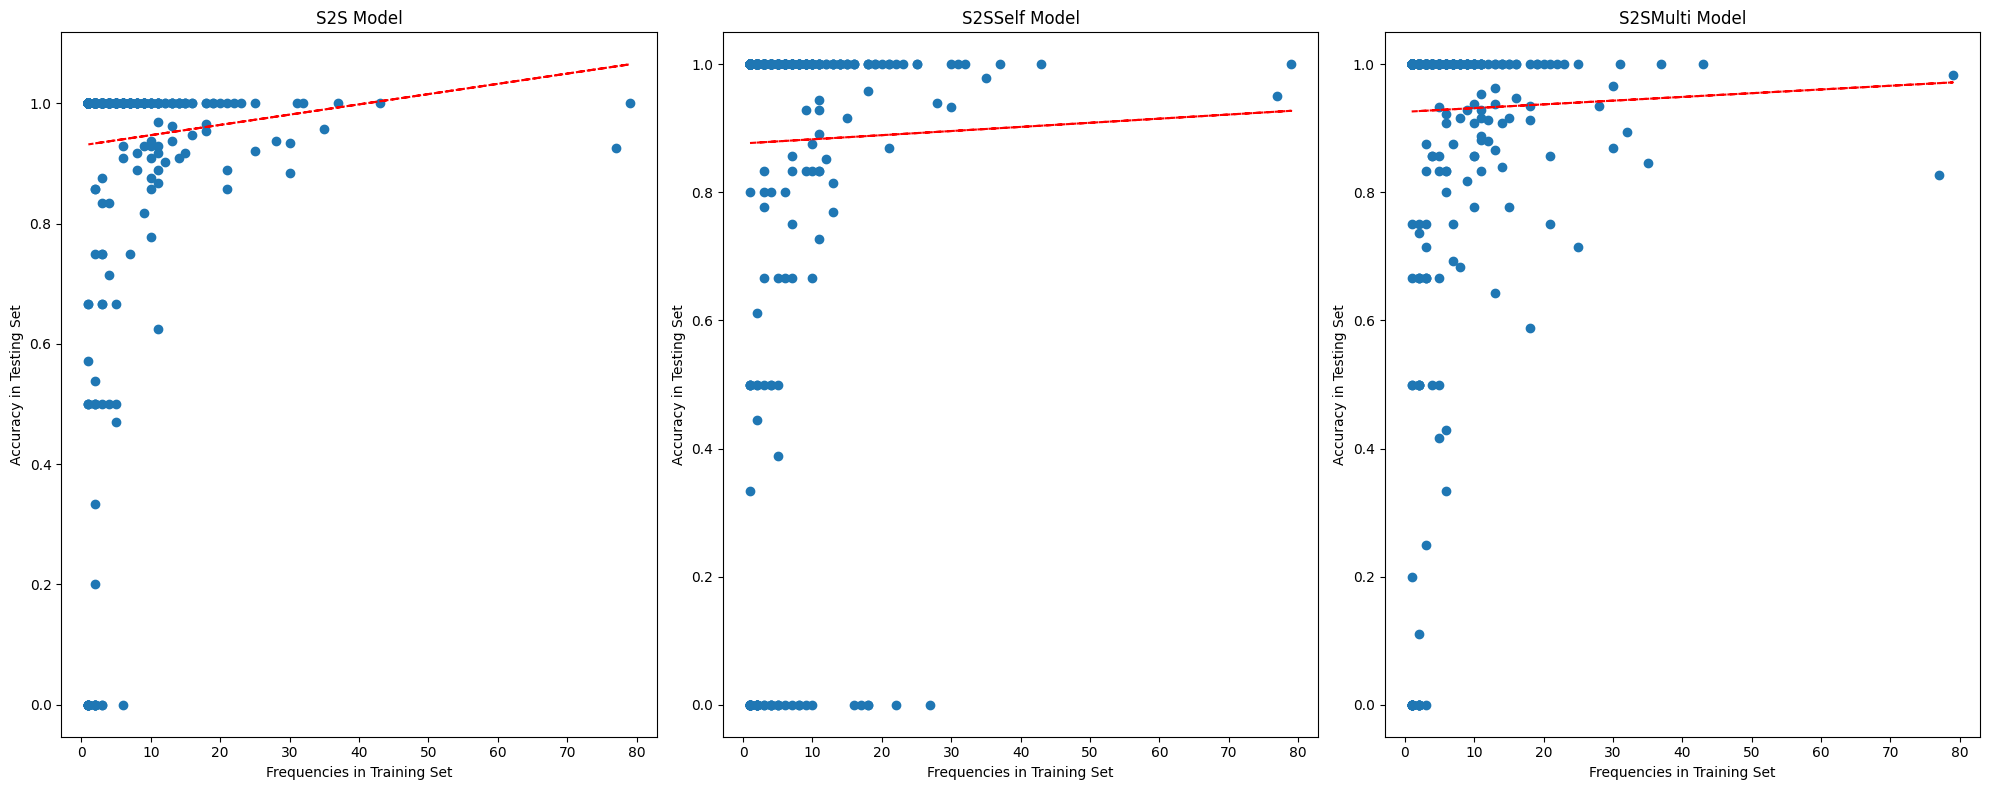

In [76]:
plot_relationships_overview(train_frequencies, test_accuracy, train_frequencies_S2SSelf, test_accuracy_S2SSelf, train_frequencies_S2SMulti, test_accuracy_S2SMulti)

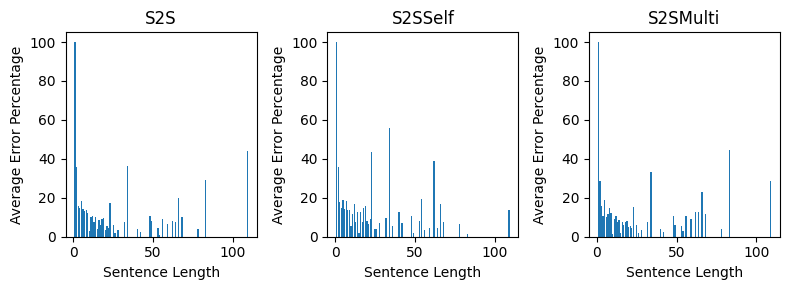

In [83]:
def analyze_error_by_sentence_length_overview(target_sentences, output_sentences, model_name):
    sentence_lengths = [len(sentence) for sentence in target_sentences]
    error_percentages = [calculate_error_percentage(target_sentence, output_sentence) for target_sentence, output_sentence in zip(target_sentences, output_sentences)]

    grouped_data = {}
    for length, error_percentage in zip(sentence_lengths, error_percentages):
        if length not in grouped_data:
            grouped_data[length] = []
        grouped_data[length].append(error_percentage)

    avg_error_percentages = {length: sum(errors) / len(errors) for length, errors in grouped_data.items()}

    return avg_error_percentages

# Tính toán dữ liệu cho các mô hình
avg_error_S2S = analyze_error_by_sentence_length_overview(train_target, train_output, "S2S")
avg_error_S2SSelf = analyze_error_by_sentence_length_overview(train_target_S2SSelf, train_output_S2SSelf, "S2SSelf")
avg_error_S2SMulti = analyze_error_by_sentence_length_overview(train_target_S2SMulti, train_output_S2SMulti, "S2SMulti")


fig, axes = plt.subplots(1, 3, figsize=(8, 3)) #figsize=(20, 8)

# Đồ thị cho mô hình S2S
axes[0].bar(avg_error_S2S.keys(), avg_error_S2S.values())
axes[0].set_xlabel('Sentence Length')
axes[0].set_ylabel('Average Error Percentage')
axes[0].set_title('S2S')

# Đồ thị cho mô hình S2SSelf
axes[1].bar(avg_error_S2SSelf.keys(), avg_error_S2SSelf.values())
axes[1].set_xlabel('Sentence Length')
axes[1].set_ylabel('Average Error Percentage')
axes[1].set_title('S2SSelf')

# Đồ thị cho mô hình S2SMulti
axes[2].bar(avg_error_S2SMulti.keys(), avg_error_S2SMulti.values())
axes[2].set_xlabel('Sentence Length')
axes[2].set_ylabel('Average Error Percentage')
axes[2].set_title('S2SMulti')

plt.tight_layout()
plt.show()